# Plots and analyses for: The development of complex planning
This notebook contains the main plots and analyses for Four in a row development data. 
## load packages and data


In [1]:
import numpy as np
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as sts
import pandas as pd
import seaborn as sns
from matplotlib import rcParams,font_manager
from matplotlib.colors import ListedColormap

from fourinarowfunctions import *

datadir = "../data/"
age = pd.read_csv(datadir + "SubjectAge.csv")
pwm = pd.read_csv(datadir + "params_with_metrics.csv")
dur = pd.read_csv(datadir + "gameDurations.csv")
rts = pd.read_csv(datadir + "reactiontimes.csv")
trialdf = pd.read_csv(datadir + "trialdata.csv")
LL = pd.read_csv(datadir + "paramsLogLikelihoodsLong.csv")
NLL_wide = pd.read_csv(datadir + "paramsLogLikelihoodswide.csv")
#pwm =  pd.read_csv(datadir + "params_with_metrics_skip_first.csv") 
#pwm =  pd.read_csv(datadir + "params_with_metrics_noscale.csv")


In [2]:
NLL_wide.head()

options = ['236-R_24qFUPTZKx0SybQ', '372-R_Pwksr0eXcbCEd8d', '423-R_2VEZT2fDPyNv1gm', '436-R_UYNV3EWWRV3lLoZ', '844-R_2D6PtBpvztH0yVh' ]
  
# selecting rows based on condition
NLLselect = NLL_wide[NLL_wide['subject'].isin(options)]

NLLselect.head()

,subject,nll,nll1,nll2,nll3,nll4,nll5
42,236-R_24qFUPTZKx0SybQ,1096.4781,219.8410,220.7146,222.6340,215.3420,217.9465
63,372-R_Pwksr0eXcbCEd8d,743.6852,152.3949,145.3641,148.9972,147.9957,148.9333
65,423-R_2VEZT2fDPyNv1gm,623.8738,128.7361,125.4671,125.4256,124.4491,119.7959
66,436-R_UYNV3EWWRV3lLoZ,601.7831,121.2877,117.7842,120.2028,121.3182,121.1902
83,844-R_2D6PtBpvztH0yVh,754.2314,149.9056,153.9043,147.9349,153.5542,148.9324


In [3]:
metrics = pwm.drop(columns=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
metrics.head()
meanMetrics = metrics.groupby(['subject']).mean()
meanMetrics[meanMetrics.columns[0]].count()

159

## Data check and create dataframes

In [4]:
pwm["subject"].value_counts()


A206:R_20NeIyNUzFyrwec     5
250:R_r2BwOdT2hnmQ5WN      5
883:R_b255PQj1bstkMjD      5
A162:R_W6S2JhASxlVGYrn     5
A1144:R_1GQ4AZBwXaNGfUa    5
                          ..
866:R_31YEgt5MqfcfZMC      5
150:R_3ilNhJufw9u0JJr      5
A115:R_2SIX12SOZtVB5hi     5
217:R_1JPc2llYzw1ezqs      5
372:R_Pwksr0eXcbCEd8d      5
Name: subject, Length: 159, dtype: int64

In [5]:
#name of your data file
filename = datadir + 'trialdata.csv'
data_dict = load_data(filename, False)
parsed_dict = {}
for username, data in data_dict.items():
    try:
        parsed_dict[username] = get_parsed_data(data)
    except AssertionError as e:
        continue
usernames = parsed_dict.keys()
print(f"{len(usernames)} users with complete data")

user ? started games after completing the task. Using only the first 37 games
159 users with complete data


In [6]:
rcParams['font.family'] = "sans-serif" 
rcParams['font.weight'] = "roman" 
rcParams['font.style'] = "normal" # not 100% sure what this does but it was recommended
rcParams['font.size'] = 32 # not 100% sure what this does but it was recommended
rcParams['pdf.fonttype'] = 42
rcParams['axes.linewidth'] = 2 #thickness of the border
rcParams['xtick.major.width'] = rcParams['axes.linewidth'] # make sure line widths are consistent
rcParams['ytick.major.width'] = rcParams['axes.linewidth']
rcParams['axes.spines.right'] = False #hides right border
rcParams['axes.spines.top'] = False #hides top
rcParams['legend.frameon'] = False #hides box around the legend
rcParams['legend.fontsize'] = 18 #font size in pt
rcParams['axes.labelsize'] = 32 
rcParams['xtick.labelsize'] = 24
rcParams['ytick.labelsize'] = rcParams['xtick.labelsize']
rcParams['lines.linewidth'] = 3
rcParams['xtick.major.size'] = 5
rcParams['lines.markersize'] = 16
rcParams['ytick.major.size'] = rcParams['xtick.major.size']

username2studyid = {username: username.split(":")[0] for username in usernames}
username2psiturkid = {username: username.split(":")[1] for username in usernames}

Users that have the same StudyID

Should be empty

In [7]:
duplicates = pd.DataFrame(username2studyid.items(), columns=["username", "StudyID"])
duplicates[duplicates["StudyID"].duplicated(keep=False)]

,username,StudyID
93,866:R_1gV06gSb8WYiLyG,866
111,866:R_31YEgt5MqfcfZMC,866


In [8]:
#create age bins and dataframes

bins = [7, 12, 17, 25]
ageBinrNr2Value = {0: 10, 1: 15, 2:21}
age['ageBin'] = pd.cut(age['FlooredAge'], bins)
age['ageBinNr'] = age['ageBin'].cat.codes
age['ageBinValue'] = age.apply(lambda row: ageBinrNr2Value.get(row['ageBinNr'], 0), axis = 1)
dur["MainDurationMinutes"] = pd.to_numeric(dur["MainDurationSeconds"]) / 60
dur["TotalDurationMinutes"] = pd.to_numeric(dur["TotalDurationSeconds"], errors='coerce') / 60
dur["StudyID"] = dur["User"].apply(lambda x: username2studyid[x])
rts["TotalMoves"] = rts["UserMoves"] + rts["OpponentMoves"]
rts["StudyID"] = rts["User"].apply(lambda x: username2studyid[x])
gameCat = pd.merge(rts, age, on="StudyID", how="left")
raw_metrics = pwm.loc[:,("subject", "fold", "planning depth", "feature drop rate", "heuristic quality", "elo")]
raw_metrics["StudyID"] = raw_metrics["subject"].apply(lambda x: username2studyid[x])
raw_metrics = pd.merge(raw_metrics, age, on="StudyID", how="left")
metrics = raw_metrics.dropna(subset=['ExactAge'])

dropped_nans = raw_metrics[~raw_metrics.index.isin(metrics.index)]
print(f"Dropped rows with nans: {len(dropped_nans)}")
dropped_nans
#subject A1153 is 27 years old so is excluded.

Dropped rows with nans: 5


,subject,fold,planning depth,feature drop rate,heuristic quality,elo,StudyID,DoB,Gender,ExactAge,FlooredAge,TaskDate,ageBin,ageBinNr,ageBinValue
615,A1153:R_1CwnNA5xXOlHq5l,1,2.339580,0.31479,0.368033,-116,A1153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
616,A1153:R_1CwnNA5xXOlHq5l,2,0.028949,0.36320,0.406567,-116,A1153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
617,A1153:R_1CwnNA5xXOlHq5l,3,4.799050,0.49557,0.238351,-116,A1153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
618,A1153:R_1CwnNA5xXOlHq5l,4,9.922640,0.49404,0.453293,-116,A1153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
619,A1153:R_1CwnNA5xXOlHq5l,5,0.003521,0.40296,0.380365,-116,A1153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
ID_metrics = metrics["StudyID"]
print("These subjects are missing in the metrics datafile:")
age[~age.StudyID.isin(ID_metrics)]

These subjects are missing in the metrics datafile:


,StudyID,DoB,Gender,ExactAge,FlooredAge,TaskDate,ageBin,ageBinNr,ageBinValue
156,543,5/22/12,F,8.9205,8,4/21/21,"(7, 12]",0,10


In [10]:
#drop the double subject
metrics = metrics[~metrics.subject.str.contains("R_31YEgt5MqfcfZMC")] 
metrics["subject"].nunique()

157

In [11]:
metrics.groupby('ageBin').count()/5

,subject,fold,planning depth,feature drop rate,heuristic quality,elo,StudyID,DoB,Gender,ExactAge,FlooredAge,TaskDate,ageBinNr,ageBinValue
ageBin,,,,,,,,,,,,,,
"(7, 12]",55.0,55.0,55.0,55.0,55.0,55.0,55.0,55.0,55.0,55.0,55.0,55.0,55.0,55.0
"(12, 17]",51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0,51.0
"(17, 25]",51.0,51.0,51.0,51.0,51.0,51.0,51.0,50.0,51.0,51.0,51.0,51.0,51.0,51.0


In [12]:
rts.head()
rts1 = rts.groupby('StudyID').mean()
rts1.mean()
rts1.std()

GameNr            0.897032
Category          2.297371
Level            22.850363
MoveNr            0.707945
RT                1.016609
UserMoves         1.422637
OpponentMoves     1.444598
TotalMoves        2.866477
dtype: float64

# create figures for descriptives
##  model derived metrics plots

157 subjects used in this graph
157 subjects used in this graph
157 subjects used in this graph
157 subjects used in this graph


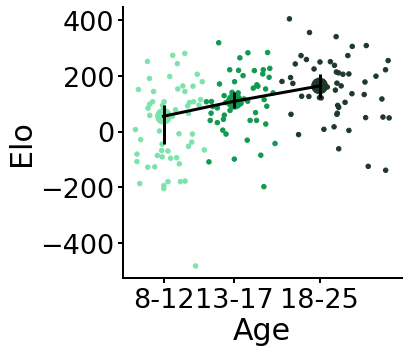

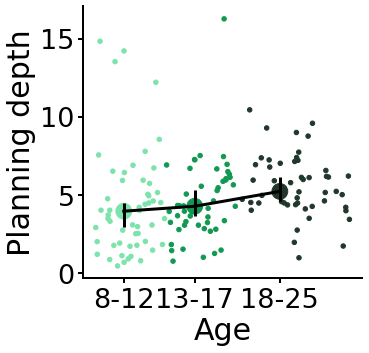

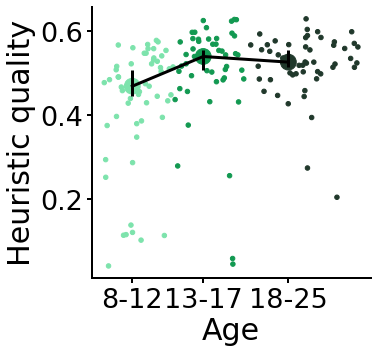

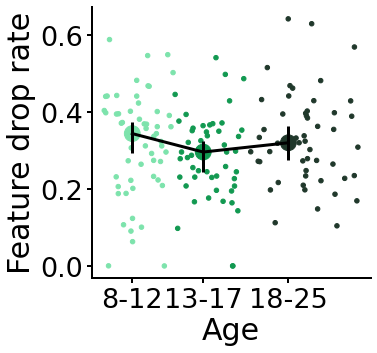

In [13]:
age_colors = ['#7DE3AC', '#129951','#20382B']
age_labels = ["8-12","13-17","18-25"]

rcParams['figure.figsize'] = (5,5) #figure size in inches

def bootstrap_median(data, repetitions = 9999, alpha = 0.05):
    n = len(data)
    medians = []
    for i in range(repetitions):
        medians.append(data.sample(n, replace=True).median())
    lo = np.percentile(medians, 100 * (    0.5 * alpha))
    hi = np.percentile(medians, 100 * (1 - 0.5 * alpha))
    return (lo, hi)

def set_labels(ax, title, reposition_ticks = True):
    ax.set_xlabel("Age", fontsize = 30)
    ax.set_ylabel(title, fontsize = 30)
    labels = age_labels.copy()
    if reposition_ticks:
        ax.set_xticks(list(ageBinrNr2Value.values()))
    ax.set_xticklabels(labels, fontsize = 27)
    ax.tick_params(labelsize=27)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.legend([])
    return ax

def plot_with_errorbars(col, title, df = None):
    if not isinstance(df, pd.DataFrame):
        df = metrics.groupby("subject").mean().reset_index()
    line_data = df.groupby("ageBinValue")[col].aggregate([("median", np.median), ("95p_ci", lambda x: bootstrap_median(x, 5000))])
    errors = np.array(line_data.apply(lambda row: [row["median"] - row["95p_ci"][0], row["95p_ci"][1] - row["median"]], axis = 1).tolist()).T
    ax = line_data.plot(y = "median", yerr=errors, color='k', linewidth=3) # Line and error bars
    size = 250
    line_data.reset_index().plot.scatter("ageBinValue", "median", size, age_colors, ax=ax) # Big dots
    agebincolors = df["ageBinNr"].map({0: '#7DE3AC', 1:'#129951', 2:'#20382B'})
    df.plot.scatter("ExactAge", col, c = agebincolors, ax = ax) # small dots
    print(f"{len(df.dropna(subset=[col]))} subjects used in this graph")
    set_labels(ax, title)
    return ax

elo_plot = plot_with_errorbars("elo", "Elo")
pd_plot = plot_with_errorbars("planning depth", "Planning depth")
hq_plot = plot_with_errorbars("heuristic quality", "Heuristic quality")
fdr_plot = plot_with_errorbars("feature drop rate", "Feature drop rate")

In [14]:
elo_plot.get_figure().savefig("../data/elo_plot_scatter.pdf", dpi=300, bbox_inches='tight')
pd_plot.get_figure().savefig("../data/pd_plot_scatter.pdf", dpi=300, bbox_inches='tight')
hq_plot.get_figure().savefig("../data/hq_plot_scatter.pdf", dpi=300, bbox_inches='tight')
fdr_plot.get_figure().savefig("../data/fdr_plot_scatter.pdf", dpi=300, bbox_inches='tight')

## game duration

In [15]:
durage = pd.merge(dur, age, how="left", on="StudyID")
print(f"Subjects in data: {len(durage)}")
# only include subjects listed in the first cell
durage = durage[durage["User"].isin(usernames)]
print(f"Subjects after selection: {len(durage)}")
# Remove duplicate subjects. Duplicates creep in if on or both of params_with_metrics or the age csv's contains duplicates
durage = durage.drop_duplicates(subset=["User"], keep="first")
print(f"Subjects after filtering duplicates: {len(durage)}")
# Drop subjects for which no age was available. Check that you have the expected number of subjects left!
durage = durage.dropna(subset=["ageBin"])
print(f"Subjects with age bin: {len(durage)}")

Subjects in data: 158
Subjects after selection: 158
Subjects after filtering duplicates: 158
Subjects with age bin: 157


In [16]:
rcParams['figure.figsize'] = (6,6) #figure size in inches

def plot_freq(col, title):
    plotdata = durage.groupby("ageBin")[col].aggregate(['mean', 'sem'])
    ax = plotdata.plot(kind="bar", yerr="sem", color=[age_colors])
    set_labels(ax, title, False).tick_params("x", labelrotation=0)

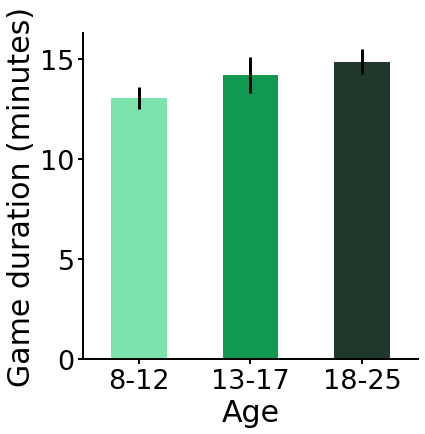

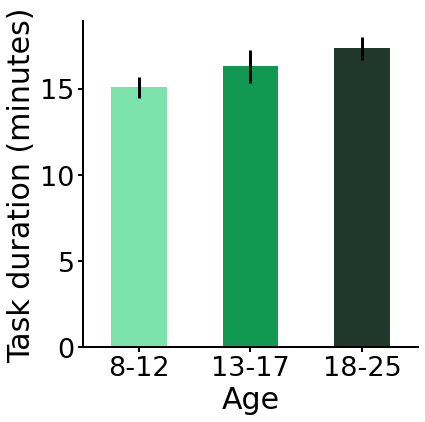

In [17]:
plot_freq("MainDurationMinutes", "Game duration (minutes)")
plot_freq("TotalDurationMinutes", "Task duration (minutes)")

## Decision times

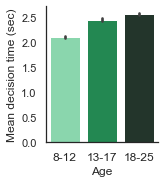

In [18]:
age_colors = ['#7DE3AC', '#129951','#20382B']
age_labels = ["8-12","13-17","18-25"]
rts2 = pd.merge(rts, age, on="StudyID", how="left")[["User", "GameNr", "RT", "TotalMoves", "ageBinNr", "ExactAge"]].drop_duplicates()
rts2 = rts2[rts2.RT > 0]
rts2.groupby(by=["User"]).mean()

#ax = sns.displot(rts2, x="RT", hue="ageBinNr", kind="kde", palette = age_colors)
#ax.set(xlim=(-5, 20))
sns.set(style = "white", rc={'figure.figsize':(2,2.5), "font.size":12,"axes.titlesize":5,"axes.labelsize":12})
ax = sns.barplot(data = rts2, y="RT", x="ageBinNr", ci=68, palette = age_colors)
sns.despine()
ax.set(xlabel='Age', ylabel='Mean decision time (sec)')
ax.set_xticklabels(age_labels, fontsize = 12)
ax.xaxis.get_label().set_fontsize(12)
ax.yaxis.get_label().set_fontsize(12)
ax
ax.figure.savefig("../data/DecisionTime.pdf", dpi=300, bbox_inches='tight')

## Corrleations with decision time

In [19]:
#mean decision time correlates with age
rts3 = rts2.dropna()
rts3 = rts3.groupby(['User']).median()
rts3 = rts3.reset_index()
rts3["subject"] = rts3["User"]

sts.spearmanr(rts3["ExactAge"], rts3["RT"])


SpearmanrResult(correlation=0.238070245483266, pvalue=0.002678021235186317)

In [20]:

rts3.head()

,User,GameNr,RT,TotalMoves,ageBinNr,ExactAge,subject
0,101:R_31SM3mwQvAhBwar,17.0,1.0900,17.0,1.0,17.4904,101:R_31SM3mwQvAhBwar
1,102:R_vdABJ1XvXNriwff,19.0,1.8420,14.0,1.0,15.0055,102:R_vdABJ1XvXNriwff
2,107:R_2ahKzS67s2u094R,19.0,1.6465,11.0,0.0,12.7260,107:R_2ahKzS67s2u094R
3,117:R_2XpQzVOPaMJjkCo,16.0,1.3540,11.0,1.0,15.9315,117:R_2XpQzVOPaMJjkCo
4,121:R_2zoxitKzRuYUblm,18.0,1.5620,14.0,1.0,14.4055,121:R_2zoxitKzRuYUblm


In [21]:
#Decision time positively correlates with heuristic quality

rtmetrics = pd.merge(meanMetrics, rts3, on="subject", how="left")[["subject", "RT", "planning depth", "feature drop rate", "heuristic quality", "elo"]].drop_duplicates()
rtmetrics = rtmetrics.dropna()
sts.spearmanr(rtmetrics["heuristic quality"], rtmetrics["RT"])

SpearmanrResult(correlation=0.4048521289909907, pvalue=1.4469434156370673e-07)

Text(21.459999999999994, 0.5, 'Decision time (sec)')

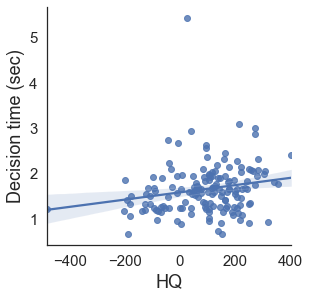

In [22]:
sns.set(style = "white", rc={"axes.labelsize":18, 'xtick.labelsize':15, 'ytick.labelsize':15})
hqcorr_plot = sns.lmplot(data=rtmetrics, y="RT", x="elo", height = 4, legend_out = True)
hqcorr_plot.axes[0,0].set_xlabel('HQ')
hqcorr_plot.axes[0,0].set_ylabel('Decision time (sec)')


In [23]:
sts.spearmanr(rtmetrics["planning depth"], rtmetrics["RT"])

SpearmanrResult(correlation=0.2374898054756408, pvalue=0.002745093211414396)

In [24]:
sts.spearmanr(rtmetrics["feature drop rate"], rtmetrics["RT"])

SpearmanrResult(correlation=-0.1034693947170199, pvalue=0.19719938346728969)

## Decision count

In [25]:
plotdata = pd.merge(rts, age, on="StudyID", how="left")[["User", "GameNr", "TotalMoves", "ageBinNr"]].drop_duplicates()
plotdata = plotdata[plotdata["ageBinNr"] >= 0]
plotdata["count"] = 1
plotdata = plotdata.groupby(["ageBinNr", "TotalMoves"])["count"].sum().reset_index().pivot(index="TotalMoves",columns="ageBinNr").fillna(0)
plotdata.loc[37] = 0 # Add an empty value at the end (36 moves is a full board)
plotdata = plotdata.sort_index()

subsPerBin = metrics[["subject", "ageBinNr"]].drop_duplicates().groupby("ageBinNr").count()
for binNr in range(len(bins) - 1):
    plotdata.iloc[:,binNr] = plotdata.iloc[:,binNr] / subsPerBin.iloc[binNr,0]



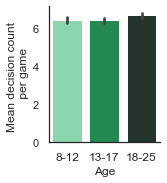

In [26]:
rts['count'] = 1
submoves = rts.groupby(by=["StudyID", "GameNr"]).sum()
submoves2 = submoves.groupby(by=["StudyID"]).mean()
submoves2 = pd.merge(submoves2, age, on="StudyID", how="left")[["StudyID", "ageBinNr", "ExactAge", "count"]].drop_duplicates()

sns.set(style = "white", rc={'figure.figsize':(2,2.5), "font.size":12,"axes.titlesize":5,"axes.labelsize":12})
ax = sns.barplot(data = submoves2, y="count", x="ageBinNr", ci=68, palette = age_colors)
sns.despine()
ax.set(xlabel='Age', ylabel='Mean decision count \n per game')
ax.set_xticklabels(age_labels, fontsize = 12)
ax.xaxis.get_label().set_fontsize(12)
ax.yaxis.get_label().set_fontsize(12)
ax
ax.figure.savefig("../data/DecisionCount.pdf", dpi=300, bbox_inches='tight')

## Correlations with decision counts

In [27]:
submoves3 = submoves2.dropna()
sts.spearmanr(submoves3["ExactAge"], submoves3["count"])

SpearmanrResult(correlation=0.1911375335394011, pvalue=0.016486685197218486)

Text(0, 0.5, 'Average frequency')

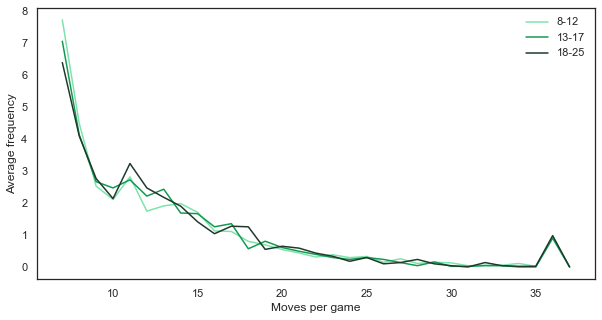

In [28]:
ax = plotdata.plot(color=['#7DE3AC', '#129951','#20382B'], figsize=(10, 5))
ax.legend(age_labels)
ax.set_xlabel("Moves per game")
ax.set_ylabel("Average frequency")

## opponent category

In [29]:
gameCat = gameCat.dropna(subset=['ExactAge'])
gameCat["StudyID"].nunique()

157

<ipython-input-30-bf6f24ae0777>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  gcplot.set_yticklabels(gcplot.get_yticks().astype(int), size = 12)
<ipython-input-30-bf6f24ae0777>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  gcplot.set_xticklabels(gcplot.get_xticks().astype(int), size = 12)


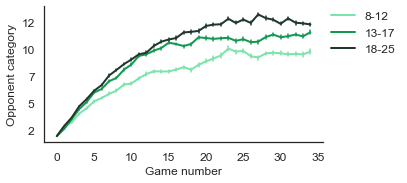

In [30]:
sns.set(style = "white", rc={'figure.figsize':(5,2.5), "font.size":12,"axes.titlesize":5,"axes.labelsize":12})
gcplot = sns.lineplot(
    data=gameCat, x="GameNr", y="Category", hue="ageBinNr", err_style="bars", ci=68,
    palette = age_colors, linewidth = 2
)
sns.despine()
gcplot.set(xlabel='Game number', ylabel='Opponent category')
gcplot.legend(age_labels, fontsize='12', bbox_to_anchor=(1.01, 1), borderaxespad=0)
gcplot.set_yticklabels(gcplot.get_yticks().astype(int), size = 12)
gcplot.set_xticklabels(gcplot.get_xticks().astype(int), size = 12)

#plt.show()
gcplot.figure.savefig("../data/staircase.pdf", dpi=300, bbox_inches='tight')

# Analyses 
## Explore the metrics data in histograms and scatterplots

Text(0, 0.5, 'Frequency')

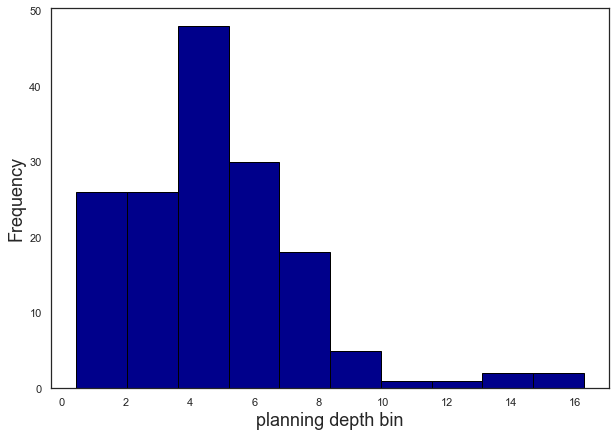

In [31]:
#histogram of the height
meanMetrics["planning depth"].plot(kind='hist', color='darkblue', edgecolor='black', figsize=(10,7))
plt.xlabel('planning depth bin', size=18)
plt.ylabel('Frequency', size=18)

Text(0, 0.5, 'Frequency')

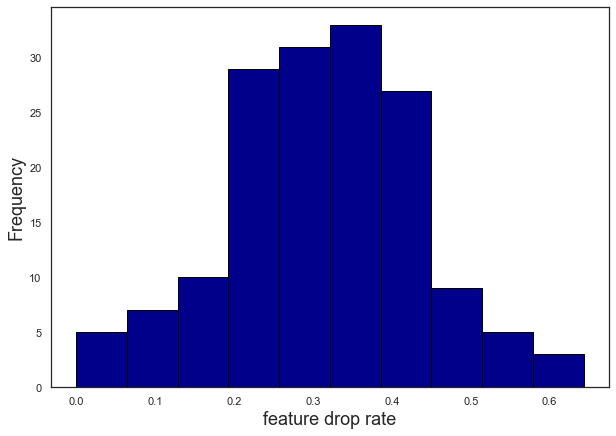

In [32]:
#histogram of the height
meanMetrics["feature drop rate"].plot(kind='hist', color='darkblue', edgecolor='black', figsize=(10,7))
plt.xlabel('feature drop rate', size=18)
plt.ylabel('Frequency', size=18)

Text(0, 0.5, 'Frequency')

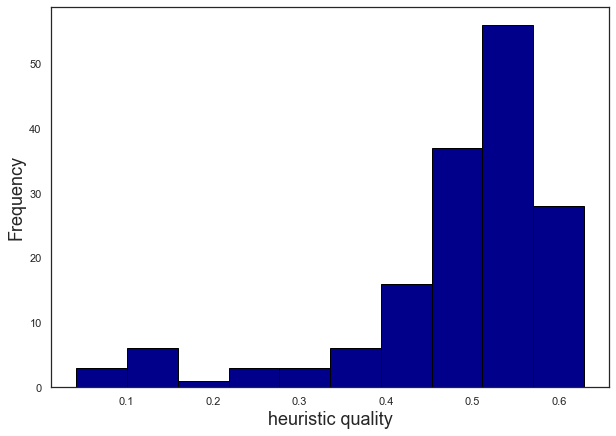

In [33]:
#histogram of the HQ
meanMetrics["heuristic quality"].plot(kind='hist', color='darkblue', edgecolor='black', figsize=(10,7))
plt.xlabel('heuristic quality', size=18)
plt.ylabel('Frequency', size=18)

# Reliability and stability checks

## Correlations between metrics

In [34]:
meanMetrics = metrics.groupby(['subject']).mean()
meanMetrics.head()

,fold,planning depth,feature drop rate,heuristic quality,elo,ExactAge,FlooredAge,ageBinNr,ageBinValue
subject,,,,,,,,,
101:R_31SM3mwQvAhBwar,3,6.133230,0.337014,0.431533,227,17.4904,17.0,1.0,15.0
102:R_vdABJ1XvXNriwff,3,7.249400,0.305772,0.624618,179,15.0055,15.0,1.0,15.0
107:R_2ahKzS67s2u094R,3,1.835382,0.362384,0.448281,179,12.7260,12.0,0.0,10.0
117:R_2XpQzVOPaMJjkCo,3,3.590356,0.196861,0.479492,109,15.9315,15.0,1.0,15.0
121:R_2zoxitKzRuYUblm,3,5.059394,0.231288,0.596912,-9,14.4055,14.0,1.0,15.0


<AxesSubplot:xlabel='heuristic quality', ylabel='planning depth'>

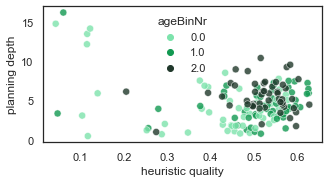

In [35]:
sns.scatterplot(data=meanMetrics, y="planning depth", x="heuristic quality", hue="ageBinNr", palette = age_colors,
                s=50, alpha = 0.8)

<AxesSubplot:xlabel='feature drop rate', ylabel='planning depth'>

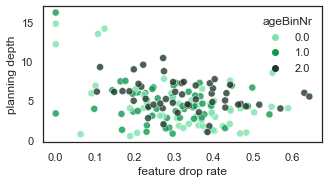

In [36]:
sns.scatterplot(data=meanMetrics, y="planning depth", x="feature drop rate", hue="ageBinNr", palette = age_colors,
               s=50, alpha = 0.8)

## check metric stability and trade-off

In [37]:
 #get p values for correlation matrix
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues


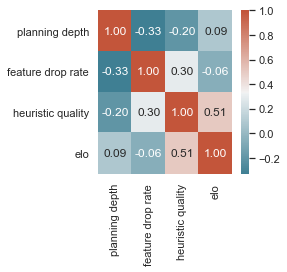

In [38]:
# are the metrics correlated?
fig, ax = plt.subplots(figsize=(3,3))
corrMetrics = meanMetrics.drop(["fold", 'ExactAge', 'FlooredAge', "ageBinNr", 'ageBinValue'], axis=1)
corrMatrix = corrMetrics.corr()
ax = sns.heatmap(corrMatrix, annot=True, fmt='.2f', cmap = sns.diverging_palette(220, 20, as_cmap=True))
ax

calculate_pvalues(corrMetrics)
ax.figure.savefig("../data/MetricsCorrelations.pdf", dpi=300, bbox_inches='tight')
# answer: yes, except pd and fdr with elo

In [39]:
corrMetrics.head()
index = corrMetrics.index
len(index) 

157

In [40]:
EloPlanning_model = np.polyfit(corrMatrix["planning depth"], corrMatrix.elo, 1)

## Residual plots

c:\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='planning depth', ylabel='elo'>

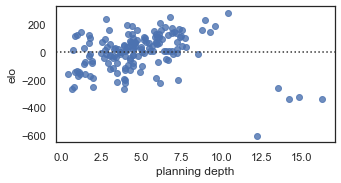

In [41]:
#residual plots
sns.residplot(meanMetrics["planning depth"], meanMetrics.elo)
#sns.residplot(meanMetrics["heuristic quality"], meanMetrics.elo)
#sns.residplot(meanMetrics["feature drop rate"], meanMetrics.elo)



## Regression metrics as function of age

In [42]:
normalized_df=(meanMetrics-meanMetrics.mean())/meanMetrics.std()

normalized_df.head()

#multiple regression between the model derived metrics using sklearn
mlr = LinearRegression() 
# fit linear regression
X = meanMetrics[['planning depth', 'heuristic quality', 'feature drop rate']]
Y = meanMetrics['elo']

mlr.fit(X, Y)
# get the slope and intercept of the line best fit.
#print(mlr.intercept_)
#print(mlr.coef_)
X2 = sm.add_constant(X)
est = sm.OLS(Y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    elo   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     24.93
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           3.45e-13
Time:                        11:10:08   Log-Likelihood:                -964.30
No. Observations:                 157   AIC:                             1937.
Df Residuals:                     153   BIC:                             1949.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -202.3219     48.70

In [43]:
#multiple regression using sklearn
mlr = LinearRegression() 
# fit linear regression
X = meanMetrics[['feature drop rate', 'ExactAge']]
Y = meanMetrics['planning depth']

mlr.fit(X, Y)
# get the slope and intercept of the line best fit.
#print(mlr.intercept_)
#print(mlr.coef_)
X2 = sm.add_constant(X)
est = sm.OLS(Y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:         planning depth   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     13.33
Date:                Fri, 03 Dec 2021   Prob (F-statistic):           4.59e-06
Time:                        11:10:08   Log-Likelihood:                -365.46
No. Observations:                 157   AIC:                             736.9
Df Residuals:                     154   BIC:                             746.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 5.4445      0.81

### Exporting the dataframe for R

In [44]:
metrics["subject"].nunique()

len(meanMetrics.index)

157

In [45]:
#Save dataframes to csv for R
metrics.to_csv('../data/metrics.csv', index = False, header=True)
meanMetrics.to_csv('../data/meanMetrics.csv', index = False, header=True)


## Plot elo as function of metrics

In [46]:
# Try doing a robust regression manually. Seaborn does this when you say robust=True except is uses Huber's t instead of Tukey's biweight (bisquare)
rlm_model = sm.RLM(meanMetrics["elo"], sm.add_constant(meanMetrics["heuristic quality"]), M=sm.robust.norms.TukeyBiweight())
rlm_results = rlm_model.fit()
print(rlm_results.params)

const               -177.334872
heuristic quality    559.498595
dtype: float64


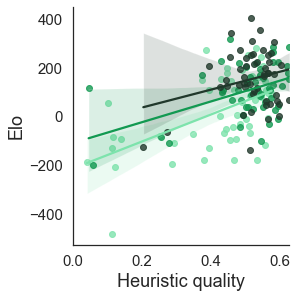

In [47]:
sns.set(style = "white", rc={"axes.labelsize":18, 'xtick.labelsize':15, 'ytick.labelsize':15})

elo_hq_plot = sns.lmplot(data=meanMetrics, y="elo", x="heuristic quality", hue = "ageBinNr", palette = age_colors, height = 4, robust = True)
elo_hq_plot.axes[0,0].set_xlabel('Heuristic quality')
elo_hq_plot.axes[0,0].set_ylabel('Elo')
elo_hq_plot.axes[0,0].set_xticks(np.arange(0, 0.8, 0.2))
elo_hq_plot._legend.remove()

elo_hq_plot.fig.savefig("../data/elo_hq.pdf", dpi=300, bbox_inches='tight')

#new_title = 'Age group'
#elo_hq_plot._legend.set_title(new_title)
#new_labels = ['8 to 12', '13 to 17', '18 to 25']
#for t, l in zip(elo_hq_plot._legend.texts, new_labels): t.set_text(l)


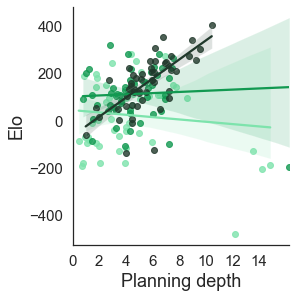

In [48]:
sns.set(style = "white", rc={"axes.labelsize":18, 'xtick.labelsize':15, 'ytick.labelsize':15})
elo_pd_plot = sns.lmplot(data=meanMetrics, y="elo", x="planning depth", hue = "ageBinNr", palette = age_colors, height = 4, legend_out = True, robust = True)
elo_pd_plot.axes[0,0].set_xlabel('Planning depth')
elo_pd_plot.axes[0,0].set_ylabel('Elo')
elo_pd_plot.axes[0,0].set_xticks(np.arange(0, 15, 2))
elo_pd_plot._legend.remove()

elo_pd_plot.fig.savefig("../data/elo_pd.pdf", dpi=300, bbox_inches='tight')
#new_title = 'Age group'
#elo_pd_plot._legend.set_title(new_title)
#new_labels = ['8 to 12', '13 to 17', '18 to 25']
#for t, l in zip(elo_pd_plot._legend.texts, new_labels): t.set_text(l)

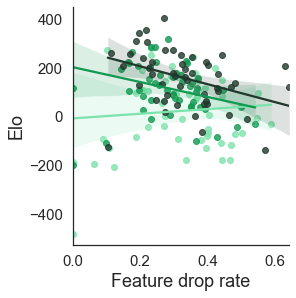

In [49]:
elo_fd_plot = sns.lmplot(data=meanMetrics, y="elo", x="feature drop rate", hue = "ageBinNr", palette = age_colors, height = 4, robust = True)
elo_fd_plot.axes[0,0].set_xlabel('Feature drop rate')
elo_fd_plot.axes[0,0].set_ylabel('Elo')
elo_fd_plot.axes[0,0].set_xticks(np.arange(0, 0.8, 0.2))
elo_fd_plot._legend.remove()

elo_fd_plot.fig.savefig("../data/elo_fdr.pdf", dpi=300, bbox_inches='tight')

#new_title = 'Age group'
#elo_fd_plot._legend.set_title(new_title)
#new_labels = ['8 to 12', '13 to 17', '18 to 25']
#for t, l in zip(elo_fd_plot._legend.texts, new_labels): t.set_text(l)


## check model fit stability (NLL)

In [50]:
LL = pd.read_csv(datadir + "paramsLogLikelihoodsLong.csv")
NLL = pd.concat([LL, metrics], axis=1)
NLL = NLL.iloc[: , 2:]
NLL.to_csv('../data/NLL.csv', index = False, header=True)

### NLL does not change as function of age
It's possible that younger children have parameter combinations that are less recoverable. The NLL did not seem to change as function of age suggests that this is not the case. 

<ipython-input-51-44c6a16c1175>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  nll_plot.set_yticklabels(nll_plot.get_yticks().astype(int), size = 25)
<ipython-input-51-44c6a16c1175>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  nll_plot.set_xticklabels(nll_plot.get_xticks().astype(int), size = 25)


[Text(5.0, 0, '5'),
 Text(10.0, 0, '10'),
 Text(15.0, 0, '15'),
 Text(20.0, 0, '20'),
 Text(25.0, 0, '25'),
 Text(30.0, 0, '30')]

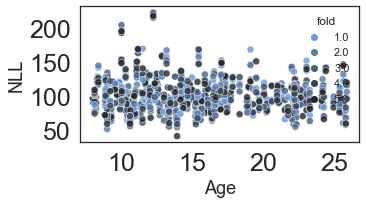

In [51]:

nll_plot = sns.scatterplot(data=NLL, y="nll", x="ExactAge", hue="fold", s=50, alpha = 0.8, palette = sns.dark_palette("#69d", reverse=True, as_cmap=True))
nll_plot.set(xlabel='Age', ylabel='NLL')
nll_plot.set_yticklabels(nll_plot.get_yticks().astype(int), size = 25)
nll_plot.set_xticklabels(nll_plot.get_xticks().astype(int), size = 25)

### Check correlations between independent fits.
This is now done over two folds but should be changed to two full independent fits (i.e., 2 runs).

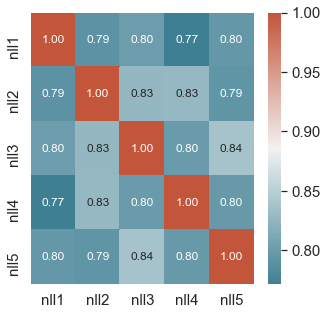

,nll1,nll2,nll3,nll4,nll5
nll1,0,0.5443,0.6722,0.3743,0.6765
nll2,0.5443,0,0.9033,0.9184,0.5036
nll3,0.6722,0.9033,0,0.5891,0.8692
nll4,0.3743,0.9184,0.5891,0,0.6196
nll5,0.6765,0.5036,0.8692,0.6196,0


In [52]:
# are the folds correlated?
fig, ax = plt.subplots(figsize=(5,5))
NLL_wide 
corrNLL = NLL_wide.drop(["nll"], axis=1)
corrMatrixNLL = corrNLL.corr()
sns.heatmap(corrMatrixNLL, annot=True, fmt='.2f', cmap = sns.diverging_palette(220, 20, as_cmap=True))
plt.show() 

calculate_pvalues(corrMatrixNLL)
# answer: yes, except pd and fdr with elo

### Export the correlations to R for plotting
Unfortunately it was easier to plot this in R than in Python. The correlation coefficients outputted at the end of this are exported to R_notebook_for_plotting_results.ipynb to create the correlation between repeated fits plots.

In [53]:
age_info = metrics.drop(columns=['StudyID', "fold", 'feature drop rate', 'heuristic quality', "planning depth", "elo", "DoB", "Gender", "ExactAge", "FlooredAge", "TaskDate", "ageBin", "ageBinValue"])
age_info.head()
# load and prep first fit
pwm = pd.read_csv(datadir + "params_with_metrics_Repeat.csv")
pwm = pd.merge(pwm, age_info, on="subject", how="left")
pwm = pwm[(pwm.subject != "A1153:R_1CwnNA5xXOlHq5l") & (pwm.subject != "866:R_31YEgt5MqfcfZMC")] #drop duplicate subject and 27 year old
# load and prep second fit
pwm2 = pd.read_csv(datadir + "params_with_metrics_Repeat2.csv")
pwm2 = pd.merge(pwm2, age_info, on="subject", how="left")
pwm2 = pwm2[(pwm2.subject != "A1153:R_1CwnNA5xXOlHq5l") & (pwm2.subject != "866:R_31YEgt5MqfcfZMC")] #drop duplicate subject and 27 year old
pwm2.subject.nunique()

157

In [54]:
#Create dataframes for correlation matrix for correlation between repeated fits
df_allfolds1 = pwm.drop(columns=['feature drop rate', 'heuristic quality', "planning depth", "elo"])
df_allfolds2 = pwm2.drop(columns=['feature drop rate', 'heuristic quality', "planning depth", "elo"])

df_allfolds1 = df_allfolds1.groupby('subject').mean()
df_allfolds2 = df_allfolds2.groupby('subject').mean()

# function to make new dataframs that only contain specific age bins
def selectdataframe(ageBinNr, dataframe1, dataframe2):
    df1 = dataframe1[dataframe1['ageBinNr'] == ageBinNr]
    df2 = dataframe2[dataframe2['ageBinNr'] == ageBinNr]
    return(df1, df2)
    
# create both fold dfs for children
df1_child, df2_child = selectdataframe(0.0, df_allfolds1, df_allfolds2)

# create both fold dfs for adolescents
df1_adol, df2_adol = selectdataframe(1.0, df_allfolds1, df_allfolds2)

# create both fold dfs for adults
df1_adult, df2_adult = selectdataframe(2.0, df_allfolds1, df_allfolds2)

# function to merge dataframes for correlation matrix for correlation between repeated fits and renames columns
def merge_runDfs(dataframe, dataframe2):
    df_allfolds1 = dataframe.rename(columns={"1": "pruning", "2": "stopping", "3": "feature drop", "4": "lapse", "5": "ac", "6": "center", "7": "2con", "8": "2uncon", "9": "three", "10": "four"})
    df_allfolds2 = dataframe2.rename(columns={"1": "pruning2", "2": "stopping2", "3": "feature drop2", "4": "lapse2", "5": "ac2", "6": "center2", "7": "2con2", "8": "2uncon2", "9": "three2", "10": "four2"})
    return pd.merge(df_allfolds1, df_allfolds2, on="subject", how="left")

# combine and name df across age
df12 = merge_runDfs(df_allfolds1, df_allfolds2)

# combine and name df children
df12_child = merge_runDfs(df1_child, df2_child)

# combine and name df adolescents
df12_adol = merge_runDfs(df1_adol, df2_adol)

# combine and name df adults
df12_adult = merge_runDfs(df1_adult, df2_adult)

df12.head()

,fold_x,pruning,stopping,feature drop,lapse,ac,center,2con,2uncon,three,...,stopping2,feature drop2,lapse2,ac2,center2,2con2,2uncon2,three2,four2,ageBinNr_y
subject,,,,,,,,,,,,,,,,,,,,,
101:R_31SM3mwQvAhBwar,3,9.415280,0.001118,0.449134,0.050108,0.658176,1.963580,1.238376,-0.068518,8.54984,...,0.008407,0.274474,0.053118,0.638218,1.676560,0.871068,0.477974,4.68108,9.98988,1.0
102:R_vdABJ1XvXNriwff,3,3.716280,0.009347,0.239574,0.053942,0.626116,0.374774,1.047714,0.882704,4.64116,...,0.013698,0.169675,0.051388,0.601168,0.216893,1.415640,1.135230,4.62698,9.09958,1.0
107:R_2ahKzS67s2u094R,3,5.833946,0.921392,0.322298,0.077770,1.204508,0.284040,1.114990,-0.544818,4.38922,...,0.605681,0.327570,0.059059,1.251336,0.394868,1.127590,-0.902337,4.69676,8.89638,0.0
117:R_2XpQzVOPaMJjkCo,3,3.019318,0.192421,0.179760,0.053563,0.929824,0.494050,0.987366,0.156717,4.81522,...,0.032266,0.119307,0.062780,0.925016,0.480092,0.803778,-0.015761,4.00468,9.57894,1.0
121:R_2zoxitKzRuYUblm,3,4.296298,0.207309,0.248142,0.056936,0.526414,0.525422,1.308260,0.414756,4.24812,...,0.006662,0.173495,0.051828,0.574078,0.423118,1.094546,0.410110,3.82518,9.82750,1.0


In [55]:
df12[["lapse", "lapse2"]].corr(method= "spearman")

,lapse,lapse2
lapse,1.00000,0.44372
lapse2,0.44372,1.00000


In [56]:
spearmanr(df12["lapse"], df12["lapse2"])

SpearmanrResult(correlation=0.44372019176501964, pvalue=5.868017966777169e-09)

In [57]:
# compute the correlation values to use in "correlation between repeated fits" in R

def corrValues(dataframe, header):
    correlations = []
    for column_name in dataframe:
        othername = column_name + "2"
        if othername in dataframe:
            correlations.append(spearmanr(dataframe[column_name], dataframe[othername]))
    print("\n" + header)
    for corr in correlations:
        print("{:.3f}".format(corr.correlation))
    print("\n" + header + " p-values")
    for corr in correlations:
        print("{:.2e}".format(corr.pvalue))
    print()


# are the folds correlated across age?
corrValues(df12, "all")

# are the folds correlated for children?
corrValues(df12_child, "children")

# are the folds correlated for adolescents?
corrValues(df12_adol, "adolescents")

# are the folds correlated for adolescents?
corrValues(df12_adult, "adults")


all
0.687
0.739
0.789
0.444
0.811
0.920
0.711
0.748
0.528
0.481

all p-values
3.05e-23
2.20e-28
1.33e-34
5.87e-09
5.86e-38
8.16e-65
1.93e-25
2.35e-29
1.24e-12
1.88e-10


children
0.692
0.821
0.841
0.552
0.858
0.831
0.648
0.587
0.589
0.612

children p-values
4.89e-09
1.75e-14
9.27e-16
1.24e-05
6.29e-17
4.32e-15
8.97e-08
2.43e-06
2.28e-06
7.05e-07


adolescents
0.617
0.656
0.727
0.400
0.727
0.950
0.695
0.694
0.522
0.447

adolescents p-values
1.42e-06
1.77e-07
1.50e-09
3.66e-03
1.59e-09
2.36e-26
1.50e-08
1.64e-08
8.58e-05
1.01e-03


adults
0.759
0.659
0.765
0.257
0.764
0.987
0.819
0.926
0.488
0.391

adults p-values
1.11e-10
1.42e-07
6.34e-11
6.83e-02
6.95e-11
2.97e-40
2.14e-13
2.23e-22
2.77e-04
4.56e-03



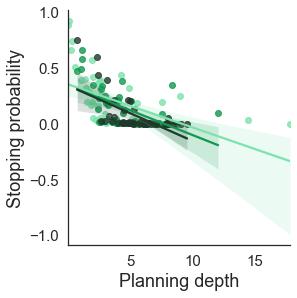

In [58]:
pwm_meanmetrics = pwm.groupby('subject').mean()
pwm_meanmetrics.head()
stopping_planning_plot = sns.lmplot(data=pwm_meanmetrics, y="2", x="planning depth", hue = "ageBinNr", palette = age_colors, height = 4)
stopping_planning_plot.axes[0,0].set_xlabel('Planning depth')
stopping_planning_plot.axes[0,0].set_ylabel('Stopping probability')
#stopping_planning_plot.axes[0,0].set_xticks(np.arange(0, 0.8, 0.2))
stopping_planning_plot._legend.remove()
